#### Import Libraries

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Project imports
from config import APP_IDS, APP_NAMES, DATA_PATHS
from scraper import PlayStoreScraper
from preprocessing import ReviewPreprocessor

# Create output directories if they don't exist (at project root level)
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Display settings
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')
#sns.set_palette('Set2')

print("Setup complete!") 

Setup complete!


### Configuration Overview

In [2]:
print("Target Apps for Analysis")
print("=" * 50)
for code, name in APP_NAMES.items():
    app_id = APP_IDS[code]
    print(f"\n{code}: {name}")
    print(f"   App ID: {app_id}")

Target Apps for Analysis

CBE: Commercial Bank of Ethiopia
   App ID: com.combanketh.mobilebanking

BOA: Bank of Abysinia
   App ID: com.boa.boaMobileBanking

DASHEN: Dashen
   App ID: com.cr2.amolelight


### Scraping Google Play Reviews

In [3]:
# Initialize the scraper
scraper = PlayStoreScraper()
# Scrape reviews for all banks
# This will collect 400+ reviews per bank
raw_df = scraper.scrape_all_apps()

Starting Google Play Store Review Scraper

[1/2] Fetching app information...

CBE: Commercial Bank of Ethiopia
App ID: com.combanketh.mobilebanking
Current Rating: 3.810345
Total Ratings: 43046
Total Reviews: 418

BOA: Bank of Abysinia
App ID: com.boa.boaMobileBanking
Current Rating: 3.16
Total Ratings: 7158
Total Reviews: 80

DASHEN: Dashen
App ID: com.cr2.amolelight
Current Rating: 4.114286
Total Ratings: 2086
Total Reviews: 16

App information saved to C:\Users\User\Desktop\portproject\customer-experience-analytics-fintech-apps\data\raw/app_info.csv

[2/2] Scraping reviews...


apps:   0%|          | 0/3 [00:00<?, ?it/s]


Scraping reviews for com.combanketh.mobilebanking...
Target: 1500 reviews (will scrape all available)
Successfully scraped 8520 reviews
Collected 8520 reviews for Commercial Bank of Ethiopia


apps:  33%|███▎      | 1/3 [00:12<00:24, 12.20s/it]


Scraping reviews for com.boa.boaMobileBanking...
Target: 1500 reviews (will scrape all available)
Successfully scraped 1258 reviews
Collected 1258 reviews for Bank of Abysinia


apps:  67%|██████▋   | 2/3 [00:16<00:07,  7.55s/it]


Scraping reviews for com.cr2.amolelight...
Target: 1500 reviews (will scrape all available)
Successfully scraped 504 reviews
Collected 504 reviews for Dashen


apps: 100%|██████████| 3/3 [00:20<00:00,  6.73s/it]


Scraping Complete!

Total reviews collected: 10282
Reviews per app:
  Commercial Bank of Ethiopia: 8520
  Bank of Abysinia: 1258
  Dashen: 504

Data saved to: C:\Users\User\Desktop\portproject\customer-experience-analytics-fintech-apps\data\raw\reviews_raw.csv


####  Display scraping results summary

In [4]:
# Display scraping results summary
if not raw_df.empty:
    print("\nRaw Data Summary")
    print("=" * 50)
    print(f"Total reviews collected: {len(raw_df)}")
    print(f"\nReviews per app:")
    print(raw_df['app_name'].value_counts())
    print(f"\nColumns: {list(raw_df.columns)}")


Raw Data Summary
Total reviews collected: 10282

Reviews per app:
app_name
Commercial Bank of Ethiopia    8520
Bank of Abysinia               1258
Dashen                          504
Name: count, dtype: int64

Columns: ['review_id', 'review_text', 'rating', 'review_date', 'user_name', 'thumbs_up', 'reply_content', 'app_code', 'app_name', 'app_id', 'source']


In [5]:
# Preview raw data
raw_df.head(10)

,review_id,review_text,rating,review_date,user_name,thumbs_up,reply_content,app_code,app_name,app_id,source
0,249f5023-5355-4635-8055-e935b45dd967,"look my app don,t hack",5,2026-02-13 00:16:13,A Google user,1,None,CBE,Commercial Bank of Ethiopia,None,Google Play
1,e4f840d2-f9a0-4de1-9387-b2a56137bd34,good,5,2026-02-12 21:29:09,A Google user,0,None,CBE,Commercial Bank of Ethiopia,None,Google Play
2,bf2e202b-7375-4a82-b31d-339ea34aee94,Good banK,5,2026-02-12 14:59:32,A Google user,0,None,CBE,Commercial Bank of Ethiopia,5.2.1,Google Play
3,0b9530f8-e07c-4ac8-8f00-68a21c870316,"CBE Mobile Banking: Easy to Use! Fast, Efficient, ""#All_in_One"" Symbol - (Bank of Ethiopia)! Gen...",5,2026-02-12 10:34:46,A Google user,0,None,CBE,Commercial Bank of Ethiopia,None,Google Play
4,6b984ad1-fe32-44ce-b986-1ccee30c4815,wow,5,2026-02-12 09:40:52,A Google user,0,None,CBE,Commercial Bank of Ethiopia,5.2.3,Google Play
5,510d6089-892a-496f-afc3-48fe1d126615,update error waiting the next update,2,2026-02-12 08:21:35,A Google user,0,None,CBE,Commercial Bank of Ethiopia,5.2.4,Google Play
6,b97db031-586b-4481-b893-513033033cf6,In my phone play store CBE mobile banking app the device is not compatible version,5,2026-02-11 22:58:27,A Google user,1,None,CBE,Commercial Bank of Ethiopia,None,Google Play
7,ec3787a6-236a-42c5-8317-cee71bdf7612,nice,5,2026-02-11 18:47:09,A Google user,0,None,CBE,Commercial Bank of Ethiopia,5.2.4,Google Play
8,8fff5aeb-63b4-457d-b94d-c88cb83c67b3,good,5,2026-02-11 17:19:59,A Google user,0,None,CBE,Commercial Bank of Ethiopia,5.2.4,Google Play
9,e0fe6849-d244-454b-a325-4c97f924a967,great,5,2026-02-11 17:03:11,A Google user,0,None,CBE,Commercial Bank of Ethiopia,5.2.4,Google Play


In [6]:
# Initialize and run preprocessor
preprocessor = ReviewPreprocessor()
success = preprocessor.process()

if success:
    processed_df = preprocessor.df
    print(f"\nProcessed dataset shape: {processed_df.shape}")
else:
    print("Preprocessing failed!")

STARTING DATA PREPROCESSING
Loading raw data...
Loaded 10282 reviews

[1/8] Checking for missing data...

Missing values:
  review_text: 7 (0.07%)
  reply_content: 10212 (99.32%)
  app_id: 2015 (19.60%)

review_text    7
dtype: int64

[2/8] Removing duplicates...
Removed 2381 duplicate reviews

[3/8] Handling missing values...
Removed 4 rows with missing critical values

[4/8] Normalizing dates...
Date range: 2014-02-17 to 2026-02-13

[5/8] Cleaning text...

[6/8] Filtering English reviews...
Removed 544 non-English reviews
Remaining English reviews: 7353

[7/8] Validating ratings...
All ratings are valid (1-5)

[8/8] Preparing final output...
Final dataset: 7353 reviews

Saving processed data...
Data saved to: C:\Users\User\Desktop\portproject\customer-experience-analytics-fintech-apps\data\processed\reviews_processed.csv

PREPROCESSING REPORT

Original records: 10282
Duplicates removed: 2381
Records with missing critical data: 4
Empty reviews removed: 0
Non-English reviews removed: 5

In [7]:
# Load processed data (in case running from saved file)
processed_df = pd.read_csv(DATA_PATHS['processed_reviews'])
print(f"Loaded {len(processed_df)} processed reviews")
processed_df.head()

Loaded 7353 processed reviews


,review_id,review_text,rating,review_date,review_year,review_month,app_code,app_name,user_name,thumbs_up,text_length,source
0,2b184e78-5b24-4948-af50-ea702dc35ebd,"It’s very hard, it’s not working.👎👎",1,2026-02-11,2026,2,BOA,Bank of Abysinia,Yemaryam lij Yemaryam lij,0,35,Google Play
1,b642100d-0a91-4481-8719-d1ca5d02d5a2,v.good,5,2026-02-11,2026,2,BOA,Bank of Abysinia,Zerihun Beyene,0,6,Google Play
2,199f8774-a008-4b97-9981-35d7ce1cfb64,some time the app would have been a problem to open,5,2026-02-10,2026,2,BOA,Bank of Abysinia,Abraham Asrat,0,51,Google Play
3,45f2bcd3-fde8-4b9b-b49d-7426427aee27,good,5,2026-02-10,2026,2,BOA,Bank of Abysinia,Ferenjo Biftu Wako,0,4,Google Play
4,3e3f5f99-6936-4e16-8758-22e9e2162f87,Its not work accurately please improve your mobile banking,1,2026-02-03,2026,2,BOA,Bank of Abysinia,Yohannes Berhe,0,58,Google Play


#### Data Quality Assessment

In [8]:
# Data quality metrics
print("Data Quality Report")
print("=" * 50)
print(f"\nTotal records: {len(processed_df)}")
print(f"Missing values: {processed_df.isnull().sum().sum()}")
print(f"Duplicate rows: {processed_df.duplicated().sum()}")

# Check if we meet the minimum requirement
min_required = 400
print(f"\nReviews per app (minimum required: {min_required}):")
app_counts = processed_df['app_name'].value_counts()
for app, count in app_counts.items():
    status = "✓" if count >= min_required else "✗"
    print(f"  {status} {app}: {count}")

total_required = 1200
total_status = "✓" if len(processed_df) >= total_required else "✗"
print(f"\n{total_status} Total reviews: {len(processed_df)} (required: {total_required})")

Data Quality Report

Total records: 7353
Missing values: 0
Duplicate rows: 0

Reviews per app (minimum required: 400):
  ✓ Commercial Bank of Ethiopia: 5950
  ✓ Bank of Abysinia: 1009
  ✗ Dashen: 394

✓ Total reviews: 7353 (required: 1200)


In [9]:
# Data types and info
print("Dataset Info")
print("=" * 50)
processed_df.info()

Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     7353 non-null   object
 1   review_text   7353 non-null   object
 2   rating        7353 non-null   int64 
 3   review_date   7353 non-null   object
 4   review_year   7353 non-null   int64 
 5   review_month  7353 non-null   int64 
 6   app_code      7353 non-null   object
 7   app_name      7353 non-null   object
 8   user_name     7353 non-null   object
 9   thumbs_up     7353 non-null   int64 
 10  text_length   7353 non-null   int64 
 11  source        7353 non-null   object
dtypes: int64(5), object(7)
memory usage: 689.5+ KB


#### Reviews Distribution by app

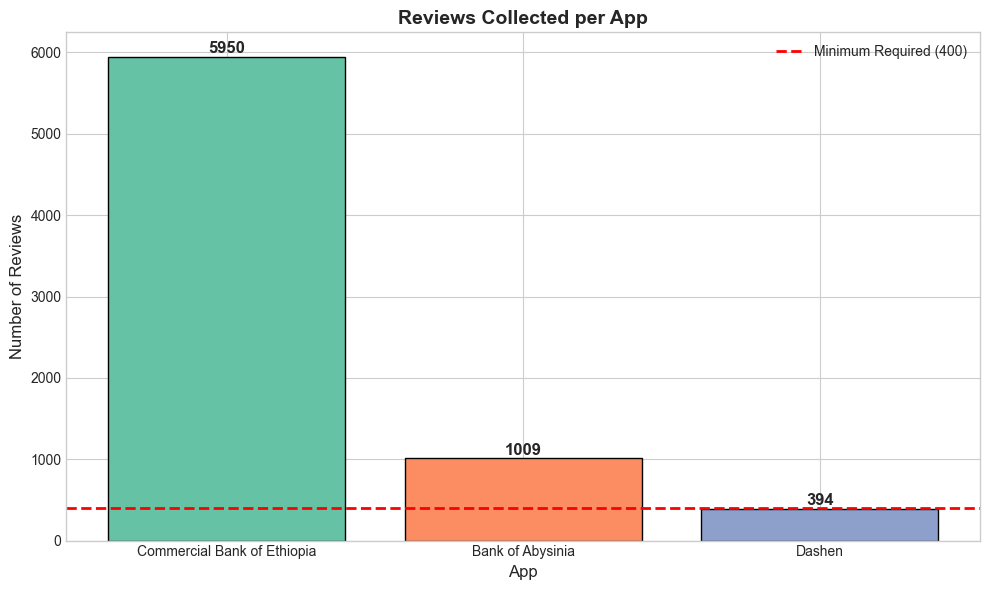

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

app_counts = processed_df['app_name'].value_counts()
colors = sns.color_palette('Set2', len(app_counts))

bars = ax.bar(app_counts.index, app_counts.values, color=colors, edgecolor='black')

# Add value labels on bars
for bar, count in zip(bars, app_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)

# Add minimum threshold line
ax.axhline(y=400, color='red', linestyle='--', linewidth=2, label='Minimum Required (400)')

ax.set_xlabel('App', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Reviews Collected per App', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../data/processed/reviews_per_app.png', dpi=300, bbox_inches='tight')
plt.show()

### Rating Distribution

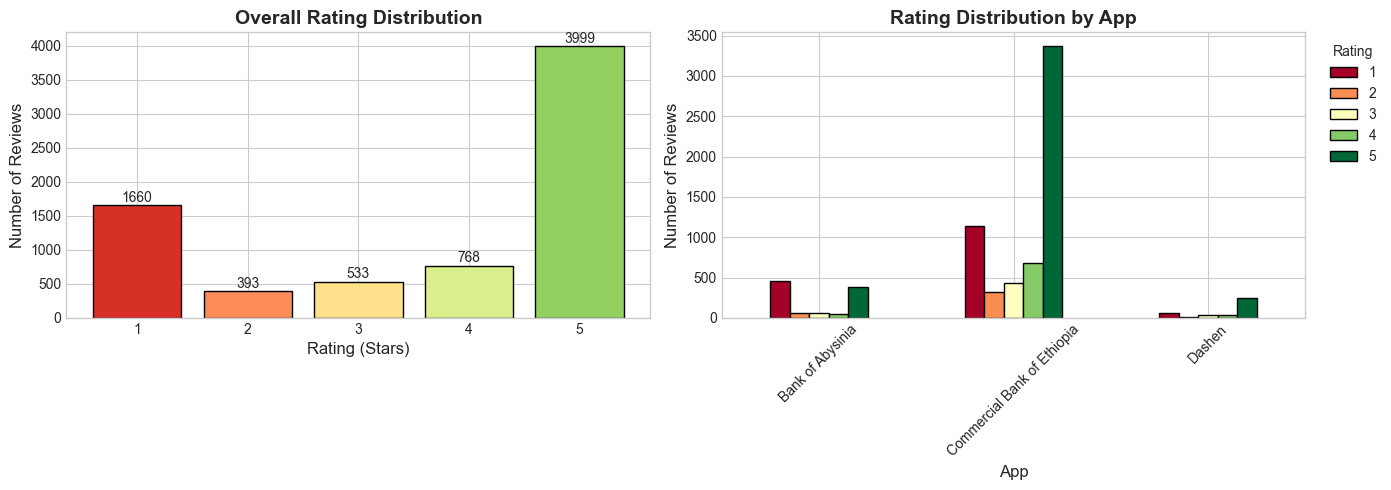

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall rating distribution
ax1 = axes[0]
rating_counts = processed_df['rating'].value_counts().sort_index()
colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60']  # Red to Green
bars = ax1.bar(rating_counts.index, rating_counts.values, color=colors, edgecolor='black')

for bar, count in zip(bars, rating_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=10)

ax1.set_xlabel('Rating (Stars)', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.set_title('Overall Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xticks([1, 2, 3, 4, 5])
# Rating distribution by app
ax2 = axes[1]
rating_by_app = processed_df.groupby(['app_name', 'rating']).size().unstack(fill_value=0)
rating_by_app.plot(kind='bar', ax=ax2, colormap='RdYlGn', edgecolor='black')

ax2.set_xlabel('App', fontsize=12)
ax2.set_ylabel('Number of Reviews', fontsize=12)
ax2.set_title('Rating Distribution by App', fontsize=14, fontweight='bold')
ax2.legend(title='Rating', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/processed/rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Average Rating by app

Average Ratings by App
                             Average Rating  Std Dev  Review Count
app_name                                                          
Bank of Abysinia                       2.86     1.85          1009
Commercial Bank of Ethiopia            3.81     1.60          5950
Dashen                                 3.98     1.50           394


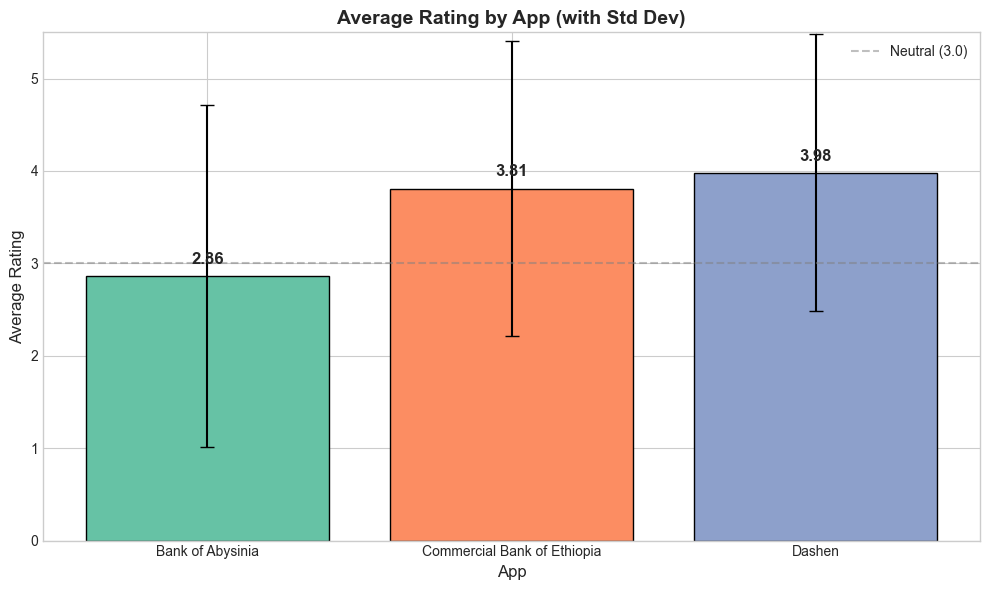

In [12]:
# Calculate average ratings
avg_ratings = processed_df.groupby('app_name')['rating'].agg(['mean', 'std', 'count'])
avg_ratings.columns = ['Average Rating', 'Std Dev', 'Review Count']
avg_ratings = avg_ratings.round(2)

print("Average Ratings by App")
print("=" * 50)
print(avg_ratings)
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

apps = avg_ratings.index
means = avg_ratings['Average Rating']
stds = avg_ratings['Std Dev']

colors = sns.color_palette('Set2', len(apps))
bars = ax.bar(apps, means, yerr=stds, capsize=5, color=colors, edgecolor='black')

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{mean:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_xlabel('App', fontsize=12)
ax.set_ylabel('Average Rating', fontsize=12)
ax.set_title('Average Rating by App (with Std Dev)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 5.5)
ax.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Neutral (3.0)')
ax.legend()

plt.tight_layout()
plt.savefig('../data/processed/average_rating_by_bank.png', dpi=300, bbox_inches='tight')
plt.show()

#### Review Text Length Analysis

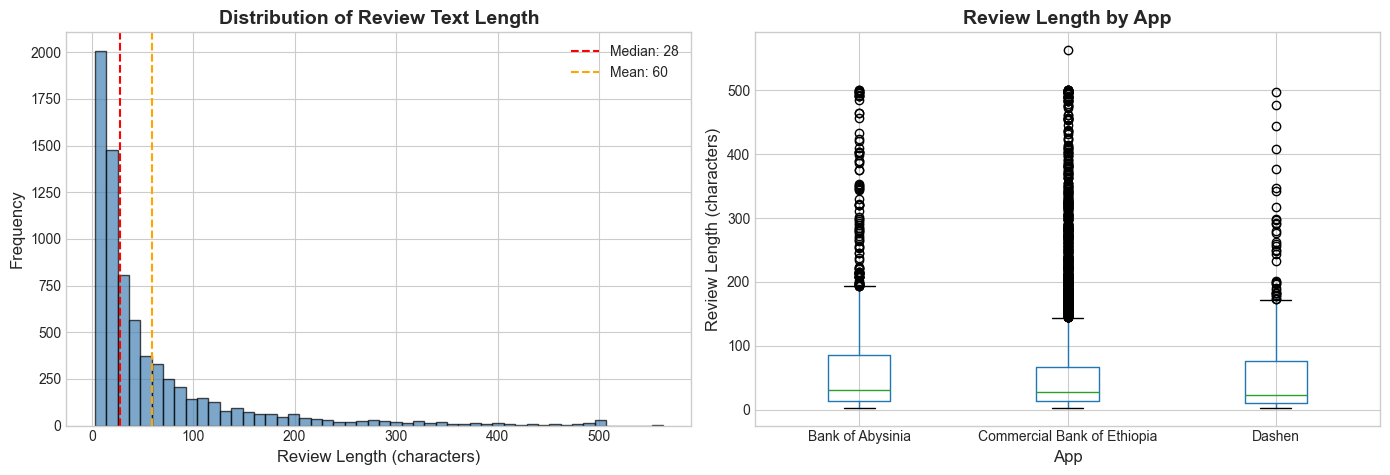

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Text length distribution
ax1 = axes[0]
processed_df['text_length'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(processed_df['text_length'].median(), color='red', linestyle='--', 
            label=f'Median: {processed_df["text_length"].median():.0f}')
ax1.axvline(processed_df['text_length'].mean(), color='orange', linestyle='--',
            label=f'Mean: {processed_df["text_length"].mean():.0f}')
ax1.set_xlabel('Review Length (characters)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Review Text Length', fontsize=14, fontweight='bold')
ax1.legend()

# Text length by app (boxplot)
ax2 = axes[1]
processed_df.boxplot(column='text_length', by='app_name', ax=ax2)
ax2.set_xlabel('App', fontsize=12)
ax2.set_ylabel('Review Length (characters)', fontsize=12)
ax2.set_title('Review Length by App', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig('../data/processed/text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### Reviews Over Time

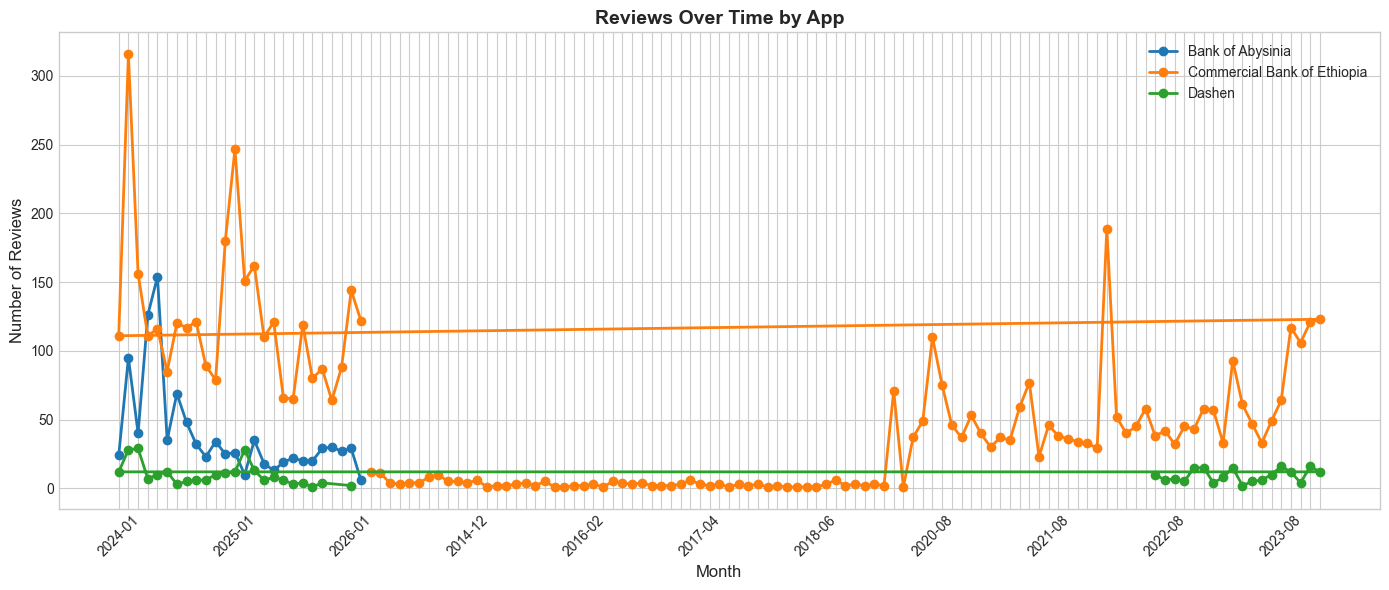

In [14]:
# Convert review_date to datetime if needed
processed_df['review_date'] = pd.to_datetime(processed_df['review_date'])

# Reviews over time (monthly)
processed_df['year_month'] = processed_df['review_date'].dt.to_period('M')

fig, ax = plt.subplots(figsize=(14, 6))

for app in processed_df['app_name'].unique():
    app_data = processed_df[processed_df['app_name'] == app]
    monthly_counts = app_data.groupby('year_month').size()
    ax.plot(monthly_counts.index.astype(str), monthly_counts.values, marker='o', label=app, linewidth=2)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Reviews Over Time by App', fontsize=14, fontweight='bold')
ax.legend()
ax.tick_params(axis='x', rotation=45)

# Show only every nth label to avoid crowding
n = max(1, len(ax.get_xticklabels()) // 10)
for i, label in enumerate(ax.get_xticklabels()):
    if i % n != 0:
        label.set_visible(False)
        plt.tight_layout()
plt.savefig('../data/processed/reviews_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

#### Sample Reviews

In [15]:
# Display sample reviews for each app
for app in processed_df['app_name'].unique():
    print(f"\n{'='*60}")
    print(f"{app}")
    print('='*60)
    app_df = processed_df[processed_df['app_name'] == app]
    # Show one positive and one negative review
    positive = app_df[app_df['rating'] >= 4].head(1)
    negative = app_df[app_df['rating'] <= 2].head(1)
    if not positive.empty:
        print(f"\n[Positive Review - {positive['rating'].values[0]} stars]")
        print(f"\"{positive['review_text'].values[0][:300]}...\"")
    if not negative.empty:
        print(f"\n[Negative Review - {negative['rating'].values[0]} stars]")
        print(f"\"{negative['review_text'].values[0][:300]}...\"")


Bank of Abysinia

[Positive Review - 5 stars]
"v.good..."

[Negative Review - 1 stars]
"It’s very hard, it’s not working.👎👎..."

Commercial Bank of Ethiopia

[Positive Review - 5 stars]
"look my app don,t hack..."

[Negative Review - 2 stars]
"update error waiting the next update..."

Dashen

[Positive Review - 5 stars]
"Nice..."

[Negative Review - 1 stars]
"worst bank ever ... they will take your money and lock you out with no reason what so ever..."


#### Data Export Summary

In [16]:
# Final summary
print(" Summary")
print("=" * 60)
print(f"\nData Collection:")
print(f"  - Source: Google Play Store")
print(f"  - Apps: {', '.join(APP_NAMES.values())}")
print(f"  - Total reviews: {len(processed_df)}")

print(f"\nData Quality:")
print(f"  - Missing values: {processed_df.isnull().sum().sum()}")
print(f"  - Duplicates: {processed_df.duplicated().sum()}")
print(f"  - Date range: {processed_df['review_date'].min()} to {processed_df['review_date'].max()}")

print(f"\nOutput Files:")
print(f"  - Raw data: {DATA_PATHS['raw_reviews']}")
print(f"  - Processed data: {DATA_PATHS['processed_reviews']}")

print(f"\nColumns in processed dataset:")
for col in processed_df.columns:
    print(f"  - {col}")

 Summary

Data Collection:
  - Source: Google Play Store
  - Apps: Commercial Bank of Ethiopia, Bank of Abysinia, Dashen
  - Total reviews: 7353

Data Quality:
  - Missing values: 0
  - Duplicates: 0
  - Date range: 2014-02-17 00:00:00 to 2026-02-13 00:00:00

Output Files:
  - Raw data: C:\Users\User\Desktop\portproject\customer-experience-analytics-fintech-apps\data\raw\reviews_raw.csv
  - Processed data: C:\Users\User\Desktop\portproject\customer-experience-analytics-fintech-apps\data\processed\reviews_processed.csv

Columns in processed dataset:
  - review_id
  - review_text
  - rating
  - review_date
  - review_year
  - review_month
  - app_code
  - app_name
  - user_name
  - thumbs_up
  - text_length
  - source
  - year_month
